In [1]:
import matplotlib.pyplot as plt
import numpy as np


from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

In [169]:
# Define standard deviation of the errors in the experimental results.
sigma = 0.01

# max_rabi_rate = 20 * 2 * np.pi
# duration =  (max_rabi_rate) # s
# duration = 120 # ns
duration = 60 # ns

# Define the number of test points obtained per run.
test_point_count = 20

# Define number of segments in the control.
segment_count = 16

# Define parameters as a set of controls with piecewise constant segments.
parameter_set = (
    np.pi
    / duration
    * (np.linspace(-1, 1, test_point_count)[:, None])
    * np.ones((test_point_count, segment_count))
)

shot_count = 1024

controls = []
for k in range(len(parameter_set)):
    controls.append({"duration": duration, "values": parameter_set[k]})

# Obtain a set of initial experimental results.
experiment_results = qctrl.functions.calculate_qchack_measurements(
        controls=controls,
        shot_count=shot_count,
    )

100%|██████████| 100/100 [00:02<00:00, 39.17it/s]


In [170]:
def get_infidelities(experiment_results):
    measurements = experiment_results.measurements
    infidelities = []
    for k in range(len(measurements)):
        infidelity = 1.0 - (measurements[k].count(1) / shot_count);
#         infidelity = abs(measurements[k].count(0) - measurements[k].count(1)) / shot_count
        infidelities.append(infidelity)
    return infidelities

In [159]:
get_infidelities(experiment_results)

[0.8330078125,
 0.8583984375,
 0.8984375,
 0.8994140625,
 0.9287109375,
 0.955078125,
 0.953125,
 0.9765625,
 0.9833984375,
 0.9892578125,
 0.990234375,
 0.9873046875,
 0.9794921875,
 0.9619140625,
 0.943359375,
 0.9306640625,
 0.8974609375,
 0.8876953125,
 0.8505859375,
 0.828125]

In [171]:
# Define initialization object for the automated closed-loop optimization.
length_scale_bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=1e-5,
    upper_bound=1e5,
)
bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=-5 * np.pi / duration,
    upper_bound=5 * np.pi / duration,
)
initializer = qctrl.types.closed_loop_optimization_step.GaussianProcessInitializer(
    length_scale_bounds=[length_scale_bound] * segment_count,
    bounds=[bound] * segment_count,
    rng_seed=0,
)

# Define state object for the closed-loop optimization.
optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
    gaussian_process_initializer=initializer,
)

Best infidelity after 0 BOULDER OPAL optimization steps: 0.9267578125


100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Best infidelity after 1 BOULDER OPAL optimization step: 0.576171875


100%|██████████| 100/100 [00:02<00:00, 39.62it/s]


Best infidelity after 2 BOULDER OPAL optimization steps: 0.4814453125


100%|██████████| 100/100 [00:02<00:00, 39.68it/s]


Best infidelity after 3 BOULDER OPAL optimization steps: 0.2802734375


100%|██████████| 100/100 [00:02<00:00, 39.94it/s]


Best infidelity after 4 BOULDER OPAL optimization steps: 0.23046875


100%|██████████| 100/100 [00:04<00:00, 21.20it/s]


Best infidelity after 5 BOULDER OPAL optimization steps: 0.06640625


100%|██████████| 100/100 [00:02<00:00, 39.16it/s]


Best infidelity after 6 BOULDER OPAL optimization steps: 0.06640625


100%|██████████| 100/100 [00:02<00:00, 38.99it/s]


Best infidelity after 7 BOULDER OPAL optimization steps: 0.06640625


100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


Best infidelity after 8 BOULDER OPAL optimization steps: 0.06640625


100%|██████████| 100/100 [00:04<00:00, 21.15it/s]


Best infidelity after 9 BOULDER OPAL optimization steps: 0.064453125


100%|██████████| 100/100 [00:02<00:00, 39.78it/s]


Best infidelity after 10 BOULDER OPAL optimization steps: 0.0615234375


100%|██████████| 100/100 [00:02<00:00, 38.26it/s]


Best infidelity after 11 BOULDER OPAL optimization steps: 0.0400390625


100%|██████████| 100/100 [00:02<00:00, 39.47it/s]


Best infidelity after 12 BOULDER OPAL optimization steps: 0.03515625


100%|██████████| 100/100 [00:02<00:00, 39.56it/s]


Infidelity: 0.0263671875


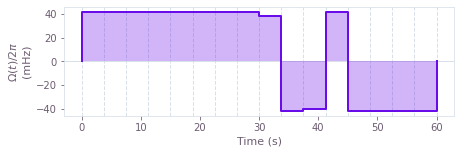

In [172]:
c_controls=[]
best_cost, best_controls = min(
    zip(get_infidelities(experiment_results), parameter_set), key=lambda params: params[0]
)
optimization_count = 0

# Run the optimization loop until the cost (infidelity) is sufficiently small.
while best_cost > 3*sigma:
    # Print the current best cost.
    optimization_steps = (
        "optimization step" if optimization_count == 1 else "optimization steps"
    )
    print(
        f"Best infidelity after {optimization_count} BOULDER OPAL {optimization_steps}: {best_cost}"
    )

    # Organize the experiment results into the proper input format.
    results = [
        qctrl.types.closed_loop_optimization_step.CostFunctionResult(
            parameters=list(parameters),
            cost=cost,
            cost_uncertainty=sigma,
        )
        for parameters, cost in zip(parameter_set, get_infidelities(experiment_results))
    ]

    # Call the automated closed-loop optimizer and obtain the next set of test points.
    optimization_result = qctrl.functions.calculate_closed_loop_optimization_step(
        optimizer=optimizer,
        results=results,
        test_point_count=test_point_count,
    )
    optimization_count += 1

    # Organize the data returned by the automated closed-loop optimizer.
    parameter_set = np.array(
        [test_point.parameters for test_point in optimization_result.test_points]
    )
    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        state=optimization_result.state
    )
    
    controls = []
    for k in range(len(parameter_set)):
        controls.append({"duration": duration, "values": parameter_set[k]})

    # Obtain experiment results that the automated closed-loop optimizer requested.
#     experiment_results = run_experiments(parameter_set)
    experiment_results = qctrl.functions.calculate_qchack_measurements(
        controls=controls,
        shot_count=shot_count,
    )
    
    # Record the best results after this round of experiments.
    cost, controls = min(
        zip(get_infidelities(experiment_results), parameter_set), key=lambda params: params[0]
    )
    if cost < best_cost:
        best_cost = cost
        best_controls = controls
    c_controls.append({"duration": duration, "values": best_controls})

# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)



In [87]:
x_gate_control = best_controls

In [146]:
h_gate_control = best_controls

In [153]:
import jsonpickle.ext.numpy as jsonpickle_numpy
jsonpickle_numpy.register_handlers()
import jsonpickle
import numpy as np

not_control = {"duration": duration, "value": h_gate_control}
json_not_control = jsonpickle.encode(not_control)
with open('h_control.json', 'w') as file:
    file.write(json_not_control)

In [147]:
# Obtain the results of the experiment.
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=[{'duration': duration, 'values': h_gate_control}],
    shot_count=shot_count,
)

100%|██████████| 100/100 [00:02<00:00, 45.04it/s]


In [148]:
measurements = experiment_results.measurements
# for k, measurement_counts in enumerate(measurements):
#     print(f"control #{k}: {measurement_counts}")

In [149]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control #0: P(|0>) = 0.51, P(|1>) = 0.49, P(|2>) = 0.00


In [14]:
repetitions = [1, 4, 16, 32, 64]

controls = []
# Create a random string of complex numbers for all control,
# but set a different repetition_count for each control.
real_part = np.random.random(size=[segment_count])
imag_part = np.random.random(size=[segment_count])
values = 0.5 * (real_part + 1j * imag_part)

for repetition_count in repetitions:
    controls.append(
        {"duration": duration, "values": values, "repetition_count": repetition_count}
    )

experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

for repetition_count, measurement_counts in zip(
    repetitions, experiment_results.measurements
):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(
        f"With {repetition_count:2d} repetitions: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_qchack_measurements has completed in 3s.
With  1 repetitions: P(|0>) = 0.42, P(|1>) = 0.58, P(|2>) = 0.00
With  4 repetitions: P(|0>) = 0.57, P(|1>) = 0.43, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 0.60, P(|1>) = 0.35, P(|2>) = 0.05
With 32 repetitions: P(|0>) = 0.52, P(|1>) = 0.34, P(|2>) = 0.14
With 64 repetitions: P(|0>) = 0.63, P(|1>) = 0.37, P(|2>) = 0.00
